# Import

In [1]:
!pip install shap
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Podstawowe biblioteki
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import numpy as np

# Biblioteka SHAP
import shap

# Biblioteka do analizy tekstu, oraz do klasyfikacji
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Bilbioteka WordCloud
from wordcloud import WordCloud

# Biblioteka do klasyfikacji, oraz odpowiednie modele
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

# Biblioteka Transformers
import transformers
from transformers import BertTokenizer
from transformers import TFAutoModel

/home/skolanko/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/skolanko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/skolanko/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Preprocessing

In [3]:
# Załadowanie danych
data = pd.read_csv('realdonaldtrump.csv')
dataOriginal = data.copy()

# Usunięcie url z treści
def remove_url(content):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',content)

# Usunięcie linków twittera do zdjęć
def remove_pic(content):
	pic = re.compile(r'pic.twitter.com/\S+')
	return pic.sub(r'',content)

# Usunięcie mentionów
def remove_ment(content):
    mention1 = re.compile(r'@ \w+')
    mention2 = re.compile(r'@\w+')
    content = mention1.sub(r'',content)
    return mention2.sub(r'',content)

# Usunięcie znaków interpunkcyjnych
def remove_punct(content):
    table = str.maketrans('', '', string.punctuation)
    return content.translate(table)

# Usunięcie html
def remove_html(content):
    html=re.compile(r'<.*?>')
    return html.sub(r'',content)

# Usunięcie emotikonów
def remove_emoji(content):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', content)

# Dekontrakcja
def decontraction(content):
    content = re.sub(r"won\'t", " will not", content)
    content = re.sub(r"won\'t've", " will not have", content)
    content = re.sub(r"can\'t", " can not", content)
    content = re.sub(r"don\'t", " do not", content)
    content = re.sub(r"can\'t've", " can not have", content)
    content = re.sub(r"ma\'am", " madam", content)
    content = re.sub(r"let\'s", " let us", content)
    content = re.sub(r"ain\'t", " am not", content)
    content = re.sub(r"shan\'t", " shall not", content)
    content = re.sub(r"sha\n't", " shall not", content)
    content = re.sub(r"o\'clock", " of the clock", content)
    content = re.sub(r"y\'all", " you all", content)
    content = re.sub(r"n\'t", " not", content)
    content = re.sub(r"n\'t've", " not have", content)
    content = re.sub(r"\'re", " are", content)
    content = re.sub(r"\'s", " is", content)
    content = re.sub(r"\'d", " would", content)
    content = re.sub(r"\'d've", " would have", content)
    content = re.sub(r"\'ll", " will", content)
    content = re.sub(r"\'ll've", " will have", content)
    content = re.sub(r"\'t", " not", content)
    content = re.sub(r"\'ve", " have", content)
    content = re.sub(r"\'m", " am", content)
    content = re.sub(r"\'re", " are", content)
    return content

# Separacja słów od liczb
def seperate_alphanumeric(content):
    words = content
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

# Znalezienie powtarzających się znaków
def cont_rep_char(content):
    tchr = content.group(0)
    if len(tchr) > 1:
        return tchr[0:2]

# Usunięcie powtarzających się znaków
def unique_char(rep, content):
    substitute = re.sub(r'(\w)\1+', rep, content)
    return substitute

# Usunięcie stop words
stop_words=stopwords.words('english')
stemmer=SnowballStemmer('english')

def remove_stopwords(text):
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(token)
    return " ".join(tokens)

# Stemming
def stem(text):
    tokens = []
    for token in text.split():
        tokens.append(stemmer.stem(token))
    return " ".join(tokens)

# Ustawienie wszystkich liter na małe
data['content'] = data['content'].apply(lambda x : x.lower())

# Usunięcie zbędnych elementów
data['content'] = data['content'].apply(lambda x : remove_pic(x))
data['content'] = data['content'].apply(lambda x : remove_url(x))
data['content'] = data['content'].apply(lambda x : remove_ment(x))
data['content'] = data['content'].apply(lambda x : remove_punct(x))
data['content'] = data['content'].apply(lambda x : remove_emoji(x))

# Reszta cyszczenia
data['content'] = data['content'].apply(lambda x : decontraction(x))
data['content'] = data['content'].apply(lambda x : seperate_alphanumeric(x))
data['content'] = data['content'].apply(lambda x : unique_char(cont_rep_char,x))
data['content'] = data['content'].apply(lambda x : remove_stopwords(x))
#data['content'] = data['content'].apply(lambda x : stem(x))

# Usunięcie duplikatów
data = data.drop_duplicates(subset=['content'])

# Usunięcie pustych wartości
data = data.dropna(subset=['content'])

# Usunięcie zbędnych kolumn
data = data.drop(['link','mentions','hashtags', 'retweets', 'favorites', 'date'], axis=1)

# NLP model

In [4]:
# Utworenie modelu
sia = SentimentIntensityAnalyzer()

# Obliczenie sentymentu
def compute_sentiment(sentence):
    result = sia.polarity_scores(sentence)
    return result['compound'], result['neg'], result['neu'], result['pos']

# Obliczenie sentymentu dla każdego tweeta
dataSentiment = data.copy()
dataSentiment['compound'], dataSentiment['negative'], dataSentiment['neutral'], dataSentiment['positive'] = zip(*data['content'].apply(compute_sentiment))

# Kategoryzacja sentymentu
def categorize_sentiment(compound):
    if compound <= -0.01:
        return 'negative'
    elif compound >= 0.01:
        return 'positive'
    else:
        return 'neutral'
dataSentiment['sentiment'] = dataSentiment['compound'].apply(categorize_sentiment)

# Prezentacja danych
pd.set_option('display.max_colwidth', None)
dataSentiment.sample(5)

,id,content,compound,negative,neutral,positive,sentiment
28871,728971726533578753,join washington today spokane tickets lynden tickets,0.2960,0.000,0.732,0.268,positive
28808,726514136838975494,trump locks delaware gop delegates trump 2016 maga,0.0000,0.000,1.000,0.000,neutral
28856,728529524468682754,governor rick perry said donald trump one talented people running presidency ive ever seen thank rick,0.7003,0.000,0.707,0.293,positive
35694,1054087893034172418,full efforts made stop onslaught illegal aliens crossing souther border people apply asylum mexico first fail us turn away courts asking us things doable,-0.8519,0.307,0.693,0.000,negative
3649,256127187894300672,even lower profit projections american firms still throwing money china obama killing investment,-0.5719,0.338,0.513,0.149,negative


# Data presentation

In [5]:
# Przykładowe dane
pd.set_option('display.max_colwidth', None)
data.sample(5)

,id,content
5278,286552014480084994,obamas deal raises taxes 77 national households obama care taxes kicking everyone paying 2 nd term
40193,1192438178747170816,degenerate washington post made story asking bill barr hold news conference never happened sources
9716,344880155585564672,danny let bosses modern family lend money play game show courage
31248,822298747421986828,thank wonderful evening washington dc inauguration
14397,447193184968667136,building military missile defense systems highest levels ever must strong prosper survive


Number of positive tweets: 23629


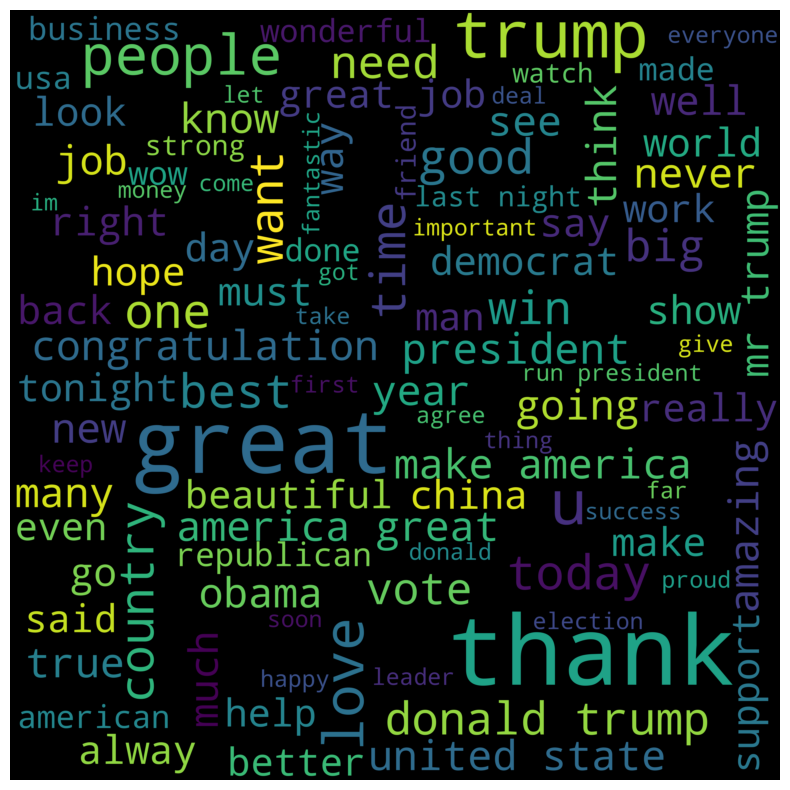

Number of negative tweets: 10473


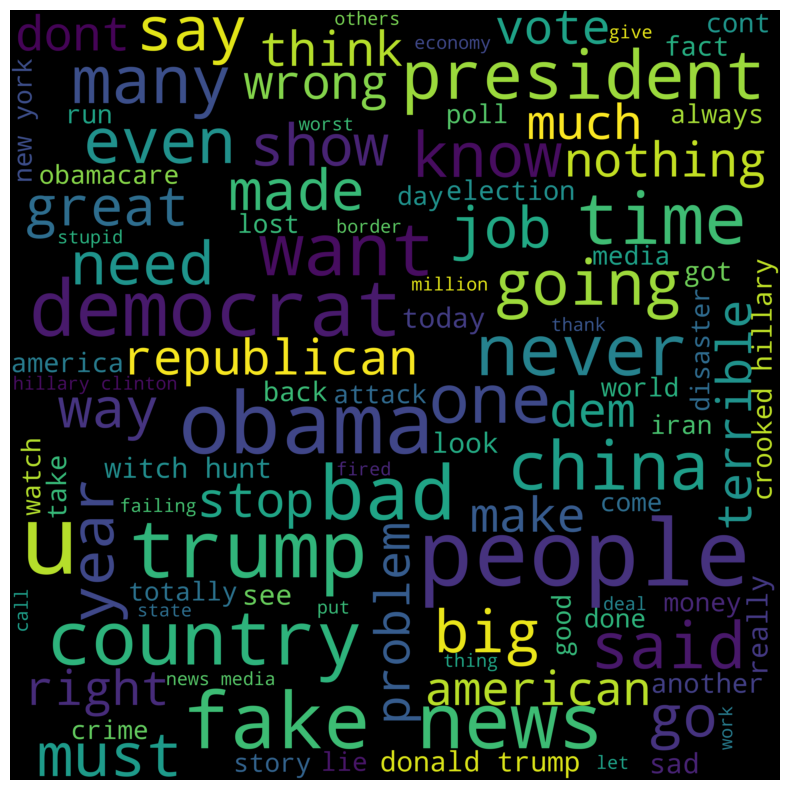

Number of neutral tweets: 6204


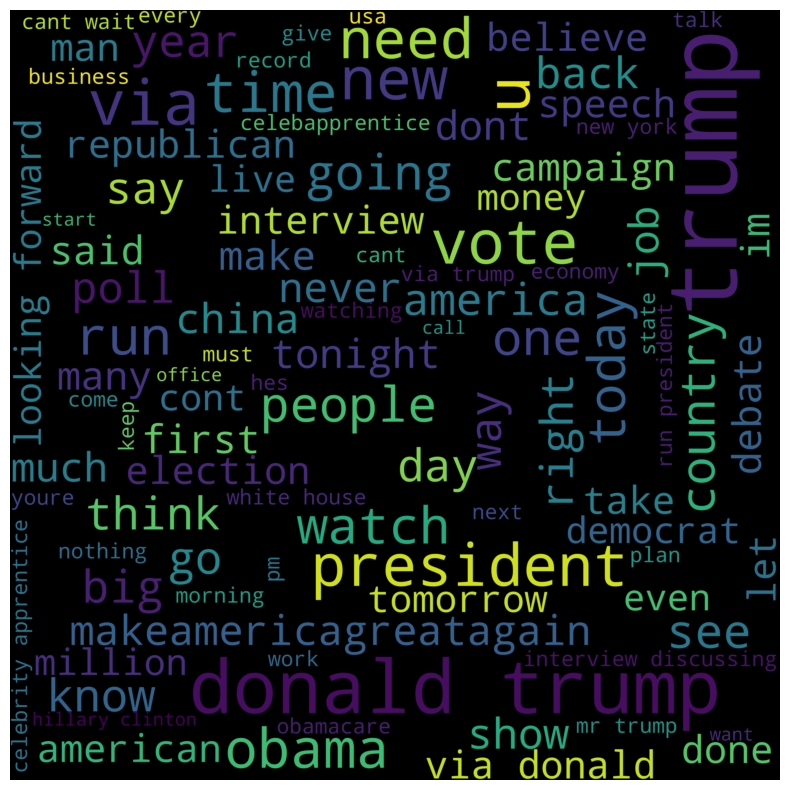

In [6]:
# # Prezentacja najczęściej występujących słów w kategoriach sentymentu
# for sentiment in ['positive', 'negative', 'neutral']:
#     sentiment_data = dataSentiment[dataSentiment['sentiment'] == sentiment]
#     print(f"Number of {sentiment} tweets: {sentiment_data.shape[0]}")
#     word_cloud_text = ' '.join(sentiment_data['content'] )
#     wordcloud = WordCloud(
#         max_font_size=100,
#         max_words=100,
#         background_color="black",
#         scale=10,
#         width=800,
#         height=800
#     ).generate(word_cloud_text)
#     plt.figure(figsize=(10,10))
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.show()

# Model trainning xD

In [16]:
import torch
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 500
embedding_dim = 50
num_classes = 2
tokenizer = Tokenizer(num_words=vocab_size, split=' ')
tokenizer.fit_on_texts(dataSentiment['content'].values)
train_tokens = tokenizer.texts_to_sequences(dataSentiment['content'].values)
train_tokens = pad_sequences(train_tokens)
# print token and corresponding word
word_index = tokenizer.word_index
for word, index in word_index.items():
    print(f"{word} => {index}")
    if index == 12:
        break
# print sentences dataSentiment['content'] and corresponding token
for i in range(5):
    print(f"Sentence: {dataSentiment['content'][i]}")
    print(f"Token: {train_tokens[i]}")


great => 1
trump => 2
president => 3
people => 4
thank => 5
us => 6
would => 7
get => 8
country => 9
new => 10
donald => 11
like => 12
Sentence: sure tune watch donald trump late night david letterman presents top ten list tonight
Token: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0 238  73  11   2  76 239  67]
Sentence: donald trump appearing view tomorrow morning discuss celebrity apprentice new book think like champion
Token: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  11   2 141 181 265 127  10 160  41  12]
Sentence: donald trump reads top ten financial tips late show david letterman funny
Token: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0  11   2 239  56]
Sentence: new blog post celebrity apprentice finale lessons learned along way
Token: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0  10 424 265 127  51]
Senten

In [59]:
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils import to_categorical
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Reshape
import torch.nn as nn
import torch
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 500
embedding_dim = 50
num_classes = 3
tokenizer = Tokenizer(num_words=vocab_size, split=' ')
tokenizer.fit_on_texts(dataSentiment['content'].values)
train_tokens = tokenizer.texts_to_sequences(dataSentiment['content'].values)
train_tokens = pad_sequences(train_tokens)

# print token and corresponding word
# word_index = tokenizer.word_index
# for word, index in word_index.items():
#     print(f"{word} => {index}")
#     if index == 12:
#         break
# print sentences dataSentiment['content'] and corresponding token
# for i in range(5):
#     print(f"Sentence: {dataSentiment['content'][i]}")
#     print(f"Token: {train_tokens[i]}")

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 64, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64, num_classes)
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :]) 
        x = self.fc(x)
        return x
    
# # Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = TextClassificationModel(vocab_size, embedding_dim, num_classes).to(device)

# Przygotowanie danych do modelu
X = train_tokens[:]
y = dataSentiment['sentiment']

X = np.array(X)
y = np.array(y)

#pprinnt few rows of X and y
# for i in range(5):
#     print(f"X: {X[i]}")
#     print(f"y: {y[i]}")

# Zakodowanie etykiet tekstowych na numeryczne
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#balance classes
from imblearn.over_sampling import SMOTE

num_classes = len(set(y_encoded))
print("Number of classes:", num_classes)
# count number of samples in each class
unique, counts = np.unique(y_encoded, return_counts=True)
print("Number of samples in each class:", dict(zip(unique, counts)))

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2)

# Przygotowanie danych do modelu
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

print("X_train_tensor shape:", X_train.shape)
print("y_train_tensor shape:", y_train.shape)


# Przygotowanie danych do modelu
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True) # True
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#print sizes of train_loader
# for i, (data, targets) in enumerate(train_loader):
#     print(f"Batch: {i:02} | Data : {data} | Targets size: {targets.size()}")


def train(dataloader, model, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    total_acc = 0
    total_count = 0
    log_interval = 1000

    for i, (data, targets) in enumerate(dataloader):
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        
        total_loss += loss.item()
        total_acc += (output.argmax(1) == targets).sum().item()
        total_count += targets.size(0)
        
        if i % log_interval == 0 and i > 0:
            cur_loss = total_loss / log_interval
            cur_acc = total_acc / total_count
            print(f'| Epoch: {epoch:02} | Batch: {i:02} | Loss: {cur_loss:.5f} | Accuracy: {cur_acc:.5f}')
            total_loss = 0
            total_acc = 0
            total_count = 0
    return total_loss / len(dataloader)

def evaluate(dataloader, model, criterion):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_count = 0
    with torch.no_grad():
        for i, (data, targets) in enumerate(dataloader):
            data, targets = data.to(device), targets.to(device)
            output = model(data)
            loss = criterion(output, targets)
            total_loss += loss.item()
            total_acc += (output.argmax(1) == targets).sum().item()
            total_count += targets.size(0)
    return total_loss / len(dataloader), total_acc / total_count

epochs = 10
# train model and save loss for plotting

train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(1, epochs + 1):
    train_epoch_loss = train(train_loader, model, criterion, optimizer, epoch)
    test_epoch_loss, test_epoch_acc = evaluate(train_loader, model, criterion)
    
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    test_acc.append(test_epoch_acc)
    
    print(f'| End of Epoch: {epoch:02} | Test Loss: {test_epoch_loss:.5f} | Test Accuracy: {test_epoch_acc:.5f}')

# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')


Device: cuda
Number of classes: 3
Number of samples in each class: {0: 10473, 1: 6204, 2: 23629}
X_train_tensor shape: torch.Size([32244, 28])
y_train_tensor shape: torch.Size([32244])
| Epoch: 01 | Batch: 1000 | Loss: 0.93332 | Accuracy: 0.57892
| Epoch: 01 | Batch: 2000 | Loss: 0.91180 | Accuracy: 0.64950
| Epoch: 01 | Batch: 3000 | Loss: 0.86725 | Accuracy: 0.66750
| Epoch: 01 | Batch: 4000 | Loss: 0.87945 | Accuracy: 0.70400
| Epoch: 01 | Batch: 5000 | Loss: 0.91228 | Accuracy: 0.69450
| Epoch: 01 | Batch: 6000 | Loss: 0.85454 | Accuracy: 0.70800
| Epoch: 01 | Batch: 7000 | Loss: 0.85031 | Accuracy: 0.73500
| Epoch: 01 | Batch: 8000 | Loss: 0.84202 | Accuracy: 0.73450
| Epoch: 01 | Batch: 9000 | Loss: 0.90646 | Accuracy: 0.71900
| Epoch: 01 | Batch: 10000 | Loss: 0.81656 | Accuracy: 0.74250
| Epoch: 01 | Batch: 11000 | Loss: 0.87141 | Accuracy: 0.73850
| Epoch: 01 | Batch: 12000 | Loss: 0.80603 | Accuracy: 0.74550
| Epoch: 01 | Batch: 13000 | Loss: 0.84167 | Accuracy: 0.74600
| Epo

Text(0, 0.5, 'Loss')

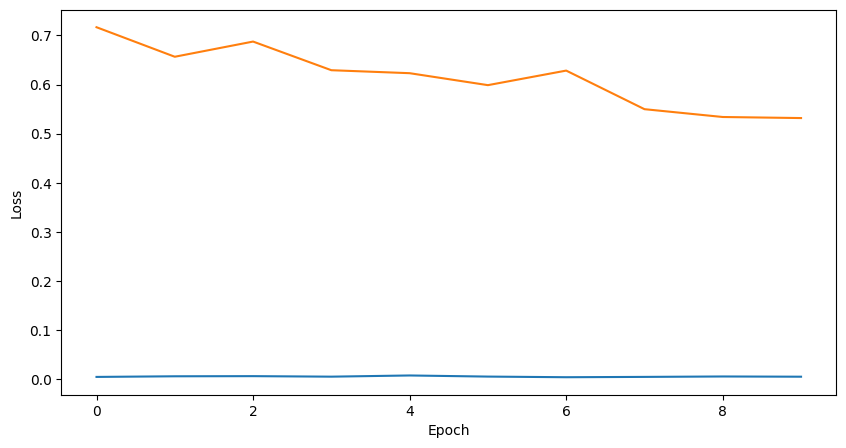

In [60]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# SHAP analysis

In [ ]:
test_string = "make amercia great again"

test_string_tokenizer = tokenizer(
    test_string,
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='np'
)
test_string_tokenizer = test_string_tokenizer['input_ids']

test1 = rf_model.predict(test_string_tokenizer)
test2 = xgb_model.predict(test_string_tokenizer)
test3 = catboost_model.predict(test_string_tokenizer)

print(label_encoder.inverse_transform(test1))
print(label_encoder.inverse_transform(test2))
print(label_encoder.inverse_transform(test3))

In [ ]:
# Analiza SHAP dla RandomForest
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

# # Wizualizacja wartości SHAP dla predykcji dla RandomForest
# shap.summary_plot(shap_values_rf, X_test)

# # Analiza SHAP dla XGBoost
# explainer_xgb = shap.TreeExplainer(xgb_model)
# shap_values_xgb = explainer_xgb.shap_values(X_test)

# # Wizualizacja wartości SHAP dla predykcji dla XGBoost
# shap.summary_plot(shap_values_xgb, X_test)

# # Analiza SHAP dla CatBoost
# explainer = shap.TreeExplainer(catboost_model)
# shap_values = explainer.shap_values(X_test)

# # Wizualizacja wartości SHAP dla predykcji dla CatBoost
# shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# # Zapisanie wyników do nowego pliku CSV
# data['number'] = [i+1 for i, _ in enumerate(data.iterrows())]
# df = data[['number'] + list(data.columns[:-1])]
# df.to_csv('tweets_sentiment_with_model.csv', index=False)
# print(df.head())

# Conclusions